## Medical Image Registration

### Install Important Libraries

In [9]:
!pip install dicom
!pip install pydicom


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# common packages 
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
# reading in dicom files
import pydicom
from pydicom import dcmread
import dicom
import glob

import cv2
import seaborn as sns


c:\Users\attam\AppData\Local\Programs\Python\Python311\Lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### Reading DICOM Data

In [5]:
def readData(folderPath):
    
    dicomDataT1 = []
    spatialDataT1 = []

    for folderPath in glob.glob(folderPath):
        file = folderPath
        dicomFile = dcmread(folderPath)    
        dicomDataT1.append(dicomFile)
        spatialDataT1.append(np.uint8(dicomFile.pixel_array))
        
    return dicomDataT1 , spatialDataT1 

In [6]:
folderPath = "Data/*"
dicomDataT1 , spatialDataT1 = readData(folderPath)

print(f"We have {len(spatialDataT1)} T1 Images")
print(len(dicomDataT1) == len(spatialDataT1))

We have 2 T1 Images
True


Text(0.5, 1.0, 'Second Scan ,Image Size = (320, 270)')

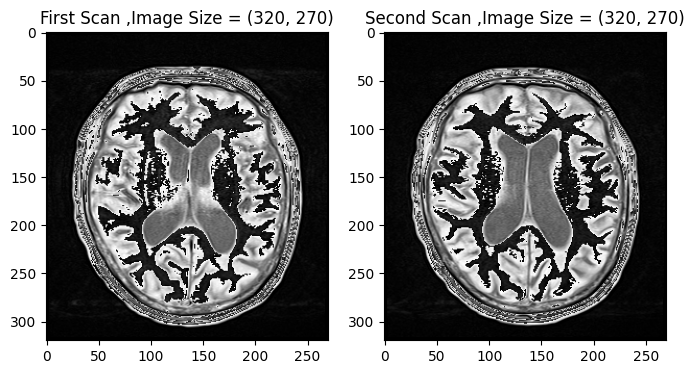

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
ax1.imshow(spatialDataT1[0], aspect='auto',cmap = "gray")
ax1.set_title(f'First Scan ,Image Size = {spatialDataT1[0].shape}')
ax2.imshow(spatialDataT1[1], aspect='auto',cmap = "gray")
ax2.set_title(f'Second Scan ,Image Size = {spatialDataT1[1].shape}')

### Difference between 2 Images

In [2]:
def getDifferenceImage(imageT1,imageT2,size =(320,270)):
    if imageT1.shape != imageT2.shape:
        imageT1 = cv2.resize(imageT1, size)
        imageT2 = cv2.resize(imageT2, size)
    diffImage = 1.0*imageT1 - imageT2
    return diffImage

In [8]:
diffImage = getDifferenceImage(spatialDataT1[1],spatialDataT1[0])

Text(0.5, 1.0, 'Difference')

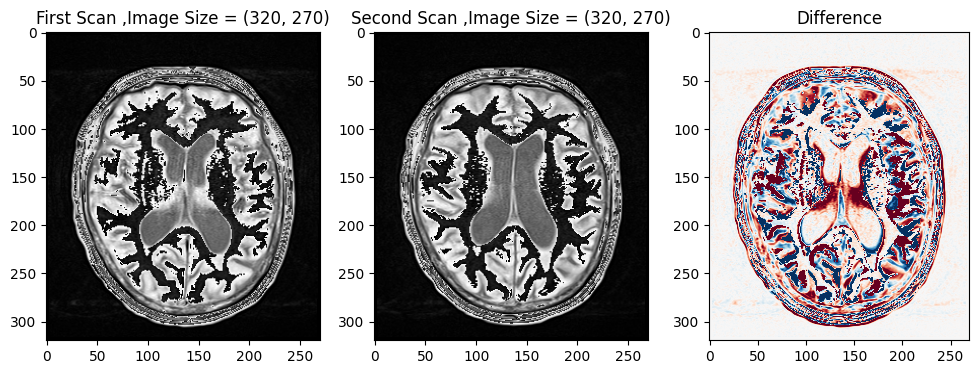

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(spatialDataT1[0], aspect='auto',cmap = "gray")
ax1.set_title(f'First Scan ,Image Size = {spatialDataT1[0].shape}')
ax2.imshow(spatialDataT1[1], aspect='auto',cmap = "gray")
ax2.set_title(f'Second Scan ,Image Size = {spatialDataT1[1].shape}')
ax3.imshow(diffImage,vmin= -100,vmax = 100,cmap = "RdBu")
ax3.set_title('Difference')

### Aligning Images

In [24]:
MAX_FEATURES = 4000
GOOD_MATCH_PERCENT = 0.35

In [65]:
def alignImages(im1Gray, im2Gray):

    # Use SIFT to get features"keypoints" and descriptors
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(im2Gray, None)

    # Use cv2.BFMatcher to match features between 2 descriptors
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # not all matches a good ones so select the best
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Check if we have enough good matches
    if len(good_matches) < 4:
        raise ValueError("Not enough good matches to calculate homography.")
    
    # Sort matches by score min distace is the best
    good_matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(good_matches) * GOOD_MATCH_PERCENT)
    good_matches = good_matches[:numGoodMatches]

    # Use cv2.drawMatches to draw good_matches
    imMatches = cv2.drawMatches(im1Gray, keypoints1, im2Gray, keypoints2, good_matches, None)
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
    ax1.imshow(imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)
    
    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    
    # use cv2.findHomography to find homography matrix
    h, mask = cv2.findHomography(points1, points2)
    
    # Use homography result from previous step to warp im1Gray
    height, width = im2Gray.shape
    
    im1Reg = cv2.warpPerspective(im1Gray, h, (width, height))

    return im1Reg, h

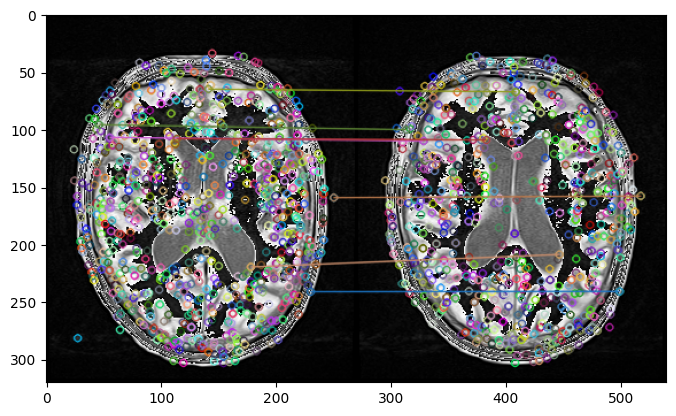

In [66]:
registeredImage, h = alignImages(spatialDataT1[0], spatialDataT1[1])

In [67]:
diffImageRegistered = getDifferenceImage(registeredImage,spatialDataT1[0])

Text(0.5, 1.0, 'Post Registration Difference')

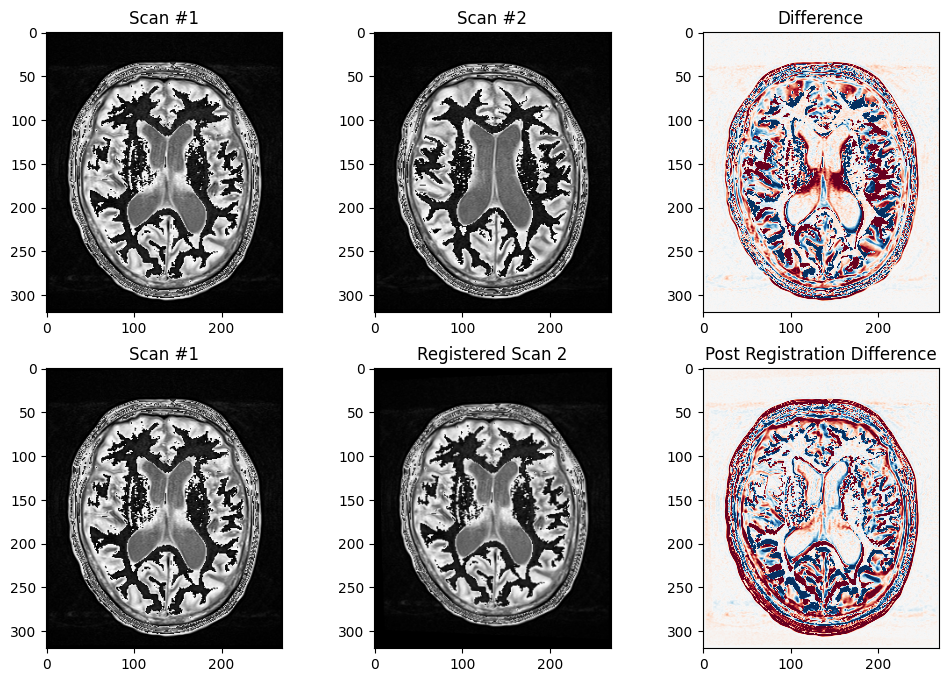

In [68]:
fig, ((ax1, ax2, ax3), (ax1a, ax4, ax5)) = plt.subplots(2, 3, figsize = (12, 8))
ax1.imshow(spatialDataT1[0], cmap = 'gray')
ax1.set_title('Scan #1')
ax2.imshow(spatialDataT1[1], cmap = 'gray')
ax2.set_title('Scan #2')
ax3.imshow(diffImage, vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference')
ax1a.imshow(spatialDataT1[0], cmap = 'gray')
ax1a.set_title('Scan #1')
ax4.imshow(registeredImage, cmap = 'gray')
ax4.set_title('Registered Scan 2')
ax5.imshow(diffImageRegistered, vmin = -100, vmax = 100, cmap = 'RdBu')
ax5.set_title('Post Registration Difference')